<a href="https://colab.research.google.com/github/jamescavanagh/unpackAI/blob/main/08_collab_own_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering - Own Code

Refactored code and notes from `08_collab.ipynb`.

## Refactor end to end collaborative filtering

Rewrite the code to create a Collaborative Filtering model on the same *MovieLens* dataset as in the Chapter 8 notebook, but with only the code necessary to load the dataset, create the DataLoaders and the model, and run it. Also add any code you personally consider important for you to understand what you are doing or verify/test things. Add you onw comment and references for your future self when you are comng back to this book.

### Imports and setup

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()



     |████████████████████████████████| 720 kB 25.2 MB/s 
     |████████████████████████████████| 46 kB 2.6 MB/s 
     |████████████████████████████████| 188 kB 44.5 MB/s 
     |████████████████████████████████| 1.2 MB 41.6 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 51 kB 256 kB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *

from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

### Loading the dataset

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
#ratings.head()
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
#movies.head()

In [ ]:
ratings = ratings.merge(movies)
#ratings.columns

### Creating the DataLoaders

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
#dls.show_batch()

In [ ]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

### Creating your model with fastai

A dot product is useful when comparing to items compared as a vector


In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.323519,1.281215,00:09
1,1.090126,1.092277,00:09
2,0.987634,0.988254,00:09
3,0.847347,0.892075,00:09
4,0.798858,0.875196,00:09


In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.982579,0.968423,00:09
1,0.872771,0.894785,00:09
2,0.674742,0.857250,00:09
3,0.475455,0.865902,00:09
4,0.381866,0.871245,00:09


### Interpreting the results

#### Rank movies using movie biases

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.969286,0.917921,00:10
1,0.838551,0.852031,00:10
2,0.623002,0.851086,00:10
3,0.405095,0.876371,00:10
4,0.305317,0.883296,00:10


In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.952827,0.925473,00:10
1,0.828606,0.849053,00:10
2,0.740711,0.814788,00:10
3,0.578897,0.800535,00:10
4,0.497056,0.800431,00:10


In [ ]:
# Embedding
class T(Module):
    def __init__(self): 
        self.a = nn.Linear(1, 3, bias=False)

def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.959915,0.930337,00:09
1,0.833497,0.852099,00:09
2,0.745027,0.820140,00:09
3,0.599381,0.808194,00:09
4,0.486168,0.808697,00:09


In [ ]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Crow: City of Angels, The (1996)',
 'Amityville II: The Possession (1982)',
 'Big Bully (1996)']

In [ ]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 "Schindler's List (1993)",
 'L.A. Confidential (1997)']

#### Find movie that are similar to another movie

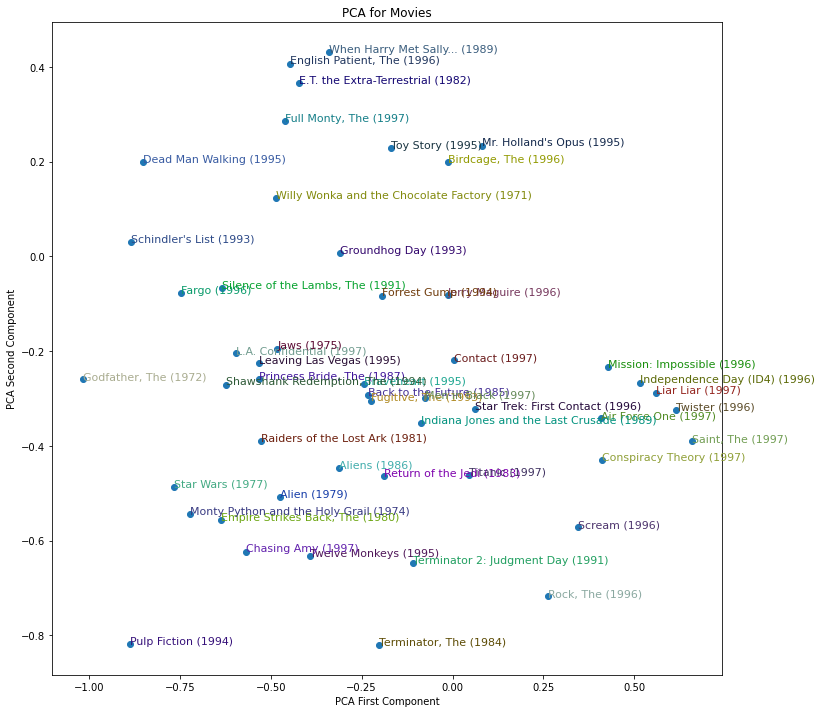

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()

movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]

plt.figure(figsize=(12,12))
plt.scatter(X, Y)
plt.title('PCA for Movies')
plt.xlabel('PCA First Component')
plt.ylabel('PCA Second Component')

for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x, y, i, color=np.random.rand(3) * 0.7, fontsize=11)

plt.show();

## Create a new model, using deep learning instead of PMF
Code above used *probabilistic matrix factorization (PMF)*. Following cells make a new model for the deep learning version.

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.956562,0.933663,00:09
1,0.847686,0.861997,00:10
2,0.733766,0.811481,00:09
3,0.591218,0.805078,00:10
4,0.492181,0.806589,00:10


In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [ ]:
embs = get_emb_sz(dls)

In [ ]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [ ]:
model = CollabNN(*embs)

learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.953206,0.949550,00:11
1,0.903633,0.882163,00:12
2,0.844873,0.861673,00:12
3,0.832490,0.848741,00:12
4,0.759336,0.849358,00:12


In [ ]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.004938,0.959271,00:14
1,0.929373,0.900729,00:14
2,0.899140,0.868442,00:14
3,0.801714,0.843908,00:13
4,0.740577,0.841868,00:13


In [ ]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

#### Find movie that are similar to another movie

# Assigment 2


In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [ ]:
# Names of the embedding tensors
learn.model.parameters

<bound method Module.parameters of EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)>

In [ ]:
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [ ]:
dls.classes['title'][7]

'20,000 Leagues Under the Sea (1954)'

In [ ]:
def extract_year(mov_title):
  return mov_title[-5:-1]

In [ ]:
ratingsTest = ratings.copy()

In [ ]:
ratingsTest['year'] = ratingsTest['title'].str.sp[-5:-1]

AttributeError: ignored

In [ ]:
ratingsTest['year'] = ratingsTest['title'].str.extract('\(([0-9]{4})\)$')

In [ ]:
dls.classes['title'].o2i['Pulp Fiction (1994)']

1191

In [ ]:
learn.i_weight.weight

Parameter containing:
tensor([[-0.0009,  0.0103,  0.0078,  ..., -0.0132, -0.0186,  0.0029],
        [-0.0191,  0.0052,  0.0002,  ...,  0.0058, -0.0140, -0.0063],
        [-0.0031, -0.0031,  0.0144,  ..., -0.0126,  0.0077,  0.0071],
        ...,
        [ 0.0147, -0.0084, -0.0018,  ..., -0.0172,  0.0030, -0.0046],
        [ 0.0134,  0.0035, -0.0193,  ..., -0.0059,  0.0036,  0.0093],
        [-0.0148, -0.0080,  0.0170,  ..., -0.0012,  0.0009,  0.0011]], requires_grad=True)

In [ ]:
learn.i_weight.weight.size()

torch.Size([1665, 50])

In [ ]:
idxs = [293]

Get the 50 latent actors associated with a particular user


In [ ]:
learn.u_weight.weight[idxs]

tensor([[ 1.1814e-02,  6.4852e-03, -1.2655e-02,  3.6727e-03, -4.3974e-03, -1.9311e-03, -9.0856e-04,  1.7783e-04, -1.5162e-03, -1.1490e-03, -8.4260e-03,  4.2311e-03,  6.1761e-04,  1.0063e-02,
          3.9520e-04,  1.4409e-02,  4.8877e-03, -4.3184e-05,  2.5674e-03,  4.2150e-03, -9.1598e-03, -1.5953e-03, -4.7838e-03, -1.1095e-02, -2.1072e-03,  6.3546e-03, -1.8603e-03, -3.2121e-03,
         -8.6919e-03,  1.5377e-03, -4.8550e-03,  8.6482e-03, -5.5307e-03,  6.2016e-04,  1.6414e-02, -3.8469e-04, -5.6059e-03, -1.3989e-02,  1.2767e-02,  1.8009e-02, -1.7397e-03,  8.7869e-05,
          2.1490e-03, -4.7838e-03,  8.1745e-03, -4.4275e-03,  2.6770e-03, -3.0132e-03, -1.6806e-02, -1.1247e-02]], grad_fn=<IndexBackward>)

In [ ]:
learn.u_weight.weight[idxs].where()

tensor([[ 1.1814e-02,  6.4852e-03, -1.2655e-02,  3.6727e-03, -4.3974e-03, -1.9311e-03, -9.0856e-04,  1.7783e-04, -1.5162e-03, -1.1490e-03, -8.4260e-03,  4.2311e-03,  6.1761e-04,  1.0063e-02,
          3.9520e-04,  1.4409e-02,  4.8877e-03, -4.3184e-05,  2.5674e-03,  4.2150e-03, -9.1598e-03, -1.5953e-03, -4.7838e-03, -1.1095e-02, -2.1072e-03,  6.3546e-03, -1.8603e-03, -3.2121e-03,
         -8.6919e-03,  1.5377e-03, -4.8550e-03,  8.6482e-03, -5.5307e-03,  6.2016e-04,  1.6414e-02, -3.8469e-04, -5.6059e-03, -1.3989e-02,  1.2767e-02,  1.8009e-02, -1.7397e-03,  8.7869e-05,
          2.1490e-03, -4.7838e-03,  8.1745e-03, -4.4275e-03,  2.6770e-03, -3.0132e-03, -1.6806e-02, -1.1247e-02]], grad_fn=<IndexBackward>)

In [ ]:
idxs = [619, 774, 613, 624]
print(f"Latent Factors for: {dls.classes['title'][idxs]}\n")
learn.u_weight.weight[idxs]

Latent Factors for: ['Gone with the Wind (1939)', 'Jaws (1975)', 'Godfather, The (1972)', 'GoodFellas (1990)']



tensor([[ 1.1295e-02, -1.7992e-03, -2.4034e-03,  4.8645e-03,  6.7398e-03, -8.7777e-03, -1.0211e-02, -1.7975e-03,  8.9037e-03,  9.2300e-03,  9.3366e-03, -1.7562e-02,  8.6487e-03,  6.2303e-04,
         -2.1089e-04, -5.8409e-03, -5.5348e-03,  3.5380e-03, -3.7288e-03, -1.3258e-02,  1.1715e-03,  1.0327e-02,  1.2160e-02, -1.4164e-03, -6.3431e-03, -3.3352e-04,  1.2594e-02, -1.2623e-02,
          1.2437e-02,  5.0900e-03,  3.6929e-03,  1.3584e-02,  1.1459e-02, -2.4397e-03,  1.6961e-03,  8.2386e-04,  8.4539e-03,  1.6625e-02,  1.3939e-02,  1.5272e-02, -4.9828e-03,  3.1981e-03,
          4.0080e-03, -1.7707e-02, -1.9355e-02, -1.7459e-02,  3.3306e-03,  4.5151e-03,  6.7994e-03, -1.1042e-02],
        [-6.6746e-03, -4.2290e-03,  5.8374e-03, -1.4493e-02, -8.8116e-03,  5.5072e-03, -1.6206e-02, -1.0319e-02,  5.7337e-03, -4.3242e-03,  9.9869e-04, -1.0484e-02, -5.3569e-03, -9.6723e-03,
         -2.6443e-03,  3.4155e-03,  1.0137e-04, -5.4620e-04, -1.3094e-04,  1.7924e-03,  1.7723e-04, -7.7677e-03,  1.7326e-

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.930639,0.952337,00:12
1,0.864856,0.870745,00:12
2,0.723437,0.831915,00:12
3,0.607902,0.816704,00:12
4,0.499192,0.817154,00:12


In [ ]:
movie_title = 'Gone with the Wind (1939))'
n = 5

movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i[movie_title]

distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])

idx = distances.argsort(descending=True)[1:n+1]
list(dls.classes['title'][idx])

['Further Gesture, A (1996)',
 'Clueless (1995)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Anastasia (1997)',
 'Balto (1995)']

In [ ]:
movie_title = 'Jaws (1975)'
n = 5

movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i[movie_title]

distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])

idx = distances.argsort(descending=True)[1:n+1]
list(dls.classes['title'][idx])

['Traveller (1997)',
 'Farewell to Arms, A (1932)',
 'Carrie (1976)',
 'Line King: Al Hirschfeld, The (1996)',
 'Wonderful, Horrible Life of Leni Riefenstahl, The (1993)']

In [ ]:
movie_title = 'Godfather, The (1972)'
n = 5

movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i[movie_title]

distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])

idx = distances.argsort(descending=True)[1:n+1]
list(dls.classes['title'][idx])

['Godfather: Part II, The (1974)',
 'Crossfire (1947)',
 'Apocalypse Now (1979)',
 'Citizen Kane (1941)',
 'Innocents, The (1961)']

In [ ]:
movie_title = 'GoodFellas (1990)'
n = 5

movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i[movie_title]

distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])

idx = distances.argsort(descending=True)[1:n+1]
list(dls.classes['title'][idx])

['Casino (1995)',
 'Good, The Bad and The Ugly, The (1966)',
 'Crumb (1994)',
 'Godfather: Part II, The (1974)',
 'Once Upon a Time in the West (1969)']

In [ ]:
# Create the Collab Filtering model

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

epoch,train_loss,valid_loss,time
0,0.949852,0.923733,00:12
1,0.823852,0.850528,00:12
2,0.597979,0.861329,00:12
3,0.386285,0.890368,00:12
4,0.262233,0.897335,00:12


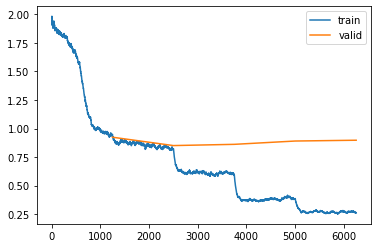

In [ ]:
wd_test = 0.0
lr = 5e-3
epochs = 5

set_seed(1988, reproducible=True)

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
model = DotProductBias(n_users, n_movies, 50)
learn_no_wd = Learner(dls, model, loss_func=MSELossFlat())
learn_no_wd.fit_one_cycle(epochs, lr, wd=wd_test)
learn_no_wd.recorder.plot_loss()

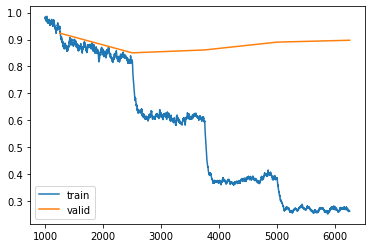

In [ ]:
learn_no_wd.recorder.plot_loss(skip_start=1000)

Looks like overfitting where the validation set's losses level off, while the training set goes down in a way that looks like overfitting

epoch,train_loss,valid_loss,time
0,1.053355,1.029261,00:12
1,1.011941,1.015972,00:12
2,1.002579,0.993225,00:12
3,0.957208,0.963042,00:12
4,0.934998,0.953659,00:12


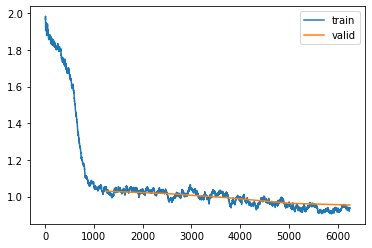

In [ ]:
wd_test = 0.75
lr = 5e-3
epochs = 5

set_seed(1988, reproducible=True)

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
model = DotProductBias(n_users, n_movies, 50)
learn_big_wd = Learner(dls, model, loss_func=MSELossFlat())
learn_big_wd.fit_one_cycle(epochs, lr, wd=wd_test)
learn_big_wd.recorder.plot_loss()

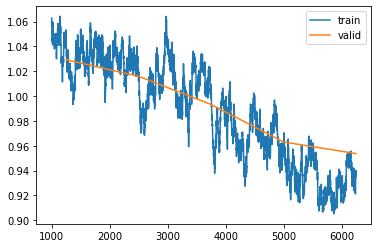

In [ ]:
learn_big_wd.recorder.plot_loss(skip_start=1000)

###What Problem does collaborate filtering solve? 

It can predict user preferences based on the interests of other users which are similar and reccomend items based on these assumptions. 


###How does it solve it?

Using latent factors which can tell what kind of items a user may like. Can use basic gradient desent based on what else other similar users like.

###Why might a collaborative filtering predictive model fail to be a very useful recommendation system?

It requires a lof of data from many users in order to create enough of a picture that is useful.


###What does a crosstab representation of collaborative filtering data look like?

Users and items and their preferences are represented as vectors within a large matrix.

###Write the code to create a crosstab representation of the MovieLens data (you might need to do some web searching!).





In [ ]:
# Code for the crosstab rep

ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
np.array(ratings.iloc[0:3])

array([[      196,       242,         3, 881250949],
       [      186,       302,         3, 891717742],
       [       22,       377,         1, 878887116]])

In [ ]:
x = [[1,2],[3,4]]
y = [[5,6],[7,8]]

dp = [[x[0][0] * y[0][0] + x[0][1] * y[1][0],
      x[0][0] * y[0][1] + x[0][1] * y[1][1]],
      [x[1][0] * y[0][0] + x[1][1] * y[1][0],
      x[1][0] * y[0][1] + x[1][1] * y[1][1]]
      ]
dotProduct = np.dot(x,y)

In [ ]:
dp

[[19, 22], [43, 50]]

In [ ]:
dotProduct

array([[19, 22],
       [43, 50]])

What is a latent factor? Why is it "latent"?

Latent factors are the preferences that a user has that has to be learned by the model. These are not explicity present in the original dataset

What is a dot product? Calculate a dot product manually using pure Python with lists.

x = [[1,2],[3,4]]
y = [[5,6],[7,8]]

dp = [[x[0][0] * y[0][0] + x[0][1] * y[1][0],
      x[0][0] * y[0][1] + x[0][1] * y[1][1]],
      [x[1][0] * y[0][0] + x[1][1] * y[1][0],
      x[1][0] * y[0][1] + x[1][1] * y[1][1]]
      ]


What does pandas.DataFrame.merge do?

This will take two dataframes and put them together, similar to pd.concat and pd.join()

What is an embedding matrix?

An embedding matrix is a way of indexing the large matrix

What is the relationship between an embedding and a matrix of one-hot-encoded vectors?

it is a matrix of one-hot vectors that doesn't take up as many computational resources for only holding one value

Why do we need Embedding if we could use one-hot-encoded vectors for the same thing?

it allows for the same task of indexing the matrix without using a ton of resources to hold a single bit with a different thing.

What does an embedding contain before we start training (assuming we're not using a pretained model)?

It is randomized 


Create a class (without peeking, if possible!) and use it.
What does x[:,0] return?

Class Dog:
  def __init__(self, bark):
    self.bark = bark
  def speak(self,name):
    return f'woof, woof, {name}'
    



###*What is a good loss function to use for MovieLens? Why? *

MSE because there's no reason to use another one on our first go since it is simple and effective. Later on, other loss functions can be experiemented with

###What would happen if we used cross-entropy loss with MovieLens? How would we need to change the model?


###What is the use of bias in a dot product model?

We should account for different influences on the movie ratings, which would be that some movies are highly regarded and others get poor reviews. Can also compensate for how some users rate their movies more positively or negatively on the whole



When using a neural network in collaborative filtering, why can we have different numbers of factors for movies and users?

Not dot product. concat embedding matricies, so it is not bound by the same rules 

Why is there an nn.Sequential in the CollabNN model?

This allows us to use different layers togethers can be used. 

What kind of model should we use if we want to add metadata about users and items, or information such as date and time, to a collaborative filtering model?

tabular model

